# Interactive structures with nglview
The [pdb_prot_align.nglview_struct](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.nglview_struct.html) module contains functions that make it easy to manipulate and visualize structures using in [nglview](https://github.com/arose/nglview).

Note that [nglview](https://github.com/arose/nglview) is designed for interactive use in a Jupyter notebook, so this example only works if run interactively.
Note also that you have to allow time for the widgets to render, so may have to run the notebook cell-by-cell waiting in between rather than running it all at once.

See [here](https://jbloomlab.github.io/pdb_prot_align/installation.html) for instructions on installing [nglview](https://github.com/arose/nglview).

This example shows how to color the structure of the CoV Spike using the results created by running `pdb_prot_align` in [the Spike CoV example](CoV_Spike.ipynb).
As input, specify the paths of the PDB file and the `*_sites.csv` file used in that example:

In [1]:
pdbfile = 'input_files/6crv.pdb'
sites_csv = 'output_files/beta_coronavirus_Spike_sites.csv'

First we import the necessary Python modules, which include [nglview](https://github.com/arose/nglview), [pdb_prot_align.colorschemes](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.colorschemes) and [pdb_prot_align.nglview_struct](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.nglview_struct.html):

In [2]:
import pandas as pd

import nglview

import pdb_prot_align

import pdb_prot_align.colorschemes
import pdb_prot_align.nglview_struct

_ColormakerRegistry()

We are going to color the structure according to the number of effective amino acids, so we get the maximum number at any site to set the color scale limits (note that it would also be reasonable to color by entropy):

In [3]:
max_neff = pd.read_csv(sites_csv)['n_effective'].max()
print(f"Max number of effective amino acids is {max_neff:.2f}")

Max number of effective amino acids is 7.50


Create a [ValueToColorMap](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.colorschemes.html#pdb_prot_align.colorschemes.ValueToColorMap) to map the numerical values to colors:

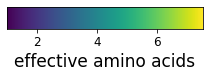

In [4]:
n_eff_color_map = pdb_prot_align.colorschemes.ValueToColorMap(
                            minvalue=1,  # min is 1 for n effective, 0 for entropy
                            maxvalue=max_neff,
                            cmap='viridis')

_ = n_eff_color_map.scale_bar(label='effective amino acids', orientation='horizontal')

Use [pdb_prot_align.nglview_struct.colorscheme_by_site](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.nglview_struct.html#pdb_prot_align.nglview_struct.colorscheme_by_site) to register a [color scheme](https://github.com/dwhswenson/contact_map/pull/62) that colors by number of effective amino acids at each site:

In [5]:
pdb_prot_align.nglview_struct.colorscheme_by_site(
                               'n_effective_by_site',
                                sites_df=sites_csv,
                                color_by=('n_effective', n_eff_color_map))

Now create a structure widget that shows a cartoon colored by site.
Note that to do this, we first clear all representations.
We then add a cartoon representation using the color scheme we have just created.
Finally, we set to the desired orientation.
To get that orientation, manually rotate and then call `view._camera_orientation`.
Note that `view.zoom()` is also useful for orienting structures:

In [6]:
view = nglview.show_structure_file(pdbfile,
                                   default_representation=False)
view.clear_representations()
view.add_cartoon(color='n_effective_by_site', selection='protein')

# desired orientation, obtained by manually orienting and then calling
# `view._camera_orientation`
desired_orientation = [195, 37, 110, 0,
                       -116, 37, 193, 0,
                       14, -222, 50, 0,
                       -154, -161, -176, 1]
view.control.orient(desired_orientation)

view

NGLWidget()

Do the same, but show a space-filling representation and color by site entropy instead.
First, make the color-mapping:

Max entropy is 2.91


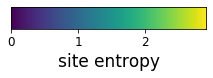

In [7]:
max_ent = pd.read_csv(sites_csv)['entropy'].max()
print(f"Max entropy is {max_ent:.2f}")

ent_color_map = pdb_prot_align.colorschemes.ValueToColorMap(
                            minvalue=0,
                            maxvalue=max_ent,
                            cmap='viridis')

_ = ent_color_map.scale_bar(label='site entropy', orientation='horizontal')

Register the color scheme and add to new widget.
If we instead add to the existing widget (`view`) it will update the appearance of that widget rather than make a new different-looking one.
Here we color just one of the monomers by site entropy, and show the others in gray (see [here](https://github.com/arose/ngl/blob/master/doc/usage/selection-language.md) for more information on the selection syntax used below):

In [8]:
pdb_prot_align.nglview_struct.colorscheme_by_site(
                               'entropy_by_site',
                                sites_df=sites_csv,
                                color_by=('entropy', ent_color_map))
view2 = nglview.show_structure_file(pdbfile,
                                    default_representation=False)
view2.clear_representations()
view2.add_spacefill(color='gray', selection='protein')
view2.add_spacefill(color='entropy_by_site', selection='protein and :A')
view2.control.orient(desired_orientation)

view2

NGLWidget()

You can save the interactive widgets to HTML files with commands like:

    nglview.write_html('image.html', view)
    
See [here](https://github.com/dwhswenson/contact_map/pull/62#issuecomment-517395187) for details.
You can also use [nbsphinx](https://nbsphinx.readthedocs.io/) to convert the entire notebook into HTML with embedded widgets.

There are several "buggy" parts of this process, however:

 1. In order for any structures to render if you render a notebook with [nbsphinx](https://nbsphinx.readthedocs.io/), you must include an HTML rendering of a widget with something like:

        from IPython.display import display, HTML
        display(HTML('image.html'))
    
    probably because this is needed to embed the NGL viewer specifications (just displaying the widget doesn't do this in HTML output).
    
 2. The camera orientation is lost in the rendered image (see [here](https://github.com/dwhswenson/contact_map/pull/62#issuecomment-583788933)), so if you want to set the orientation you need to manually edit the HTML rendering.
 
To circumvent these issues, you can use the [pdb_prot_align.nglview_struct.render_html](https://jbloomlab.github.io/pdb_prot_align/pdb_prot_align.nglview_struct.html#pdb_prot_align.nglview_struct.render_html) function, which takes care of these steps.
Here we run that function with `html_file` as `False` (so we do not write a separate HTML file) and with `remove_widget_view` as `True` (so the widget is embedded when the notebook is converted to HTML, but so that the view of the widget isn't repeated from above).

In [9]:
pdb_prot_align.nglview_struct.render_html(
                                    view,
                                    orientation=desired_orientation,
                                    remove_widget_view=True,
                                    html_file=False)